In [1]:
import sys

sys.path.append("/home/users/arustam/fwix/operator/lib/python/")
sys.path.append("/home/users/arustam/fwix/propagator/lib/python/")

In [2]:
%load_ext autoreload
%autoreload 2
import SepVector
import CudaOperator
import CudaWEM
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt


/usr/local/lib/python3.10/dist-packages/numpy/_core/getlimits.py:555: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/lib/python3.10/dist-packages/numpy/_core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/usr/local/lib/python3.10/dist-packages/numpy/_core/getlimits.py:555: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/lib/python3.10/dist-packages/numpy/_core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


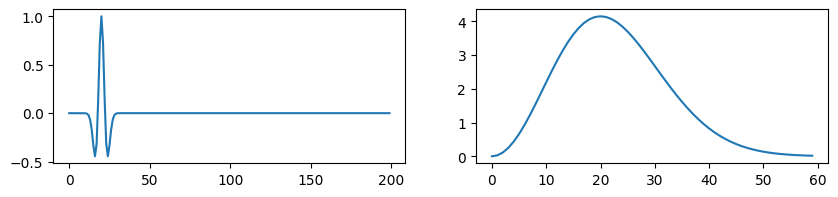

In [3]:
def ricker_wavelet(frequency, Nt, dt, t0=0):
    t = np.linspace(0, (Nt-1)*dt, Nt)
    t_shifted = t - t0
    ricker = (1 - 2 * (np.pi ** 2) * (frequency ** 2) * (t_shifted ** 2)) * np.exp(-(np.pi ** 2) * (frequency ** 2) * (t_shifted ** 2))
    return ricker

# Parameters
frequency = 10  # Ricker wavelet central frequency
Nt = 200    # Length of the wavelet in seconds
dt = 0.01      # Time sampling interval
t0 = 0.2

# Generate Ricker wavelet
wavelet = ricker_wavelet(frequency, Nt, dt, t0=t0)
W = np.fft.fft(wavelet)

dw = 1/((Nt-1)*dt) * 2*np.pi
nw = 60
f, a = plt.subplots(1,2, figsize=[10,2])
a[0].plot(wavelet, label='Ricker Wavelet')
a[1].plot(np.abs(W[:nw]), label="Spectrue")

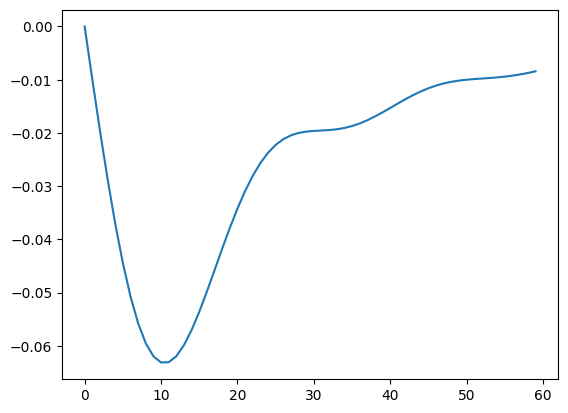

In [4]:
npml_t = 10 
amax = 1e-2

tpml = np.zeros(Nt)
tpml[:npml_t] = np.linspace(0, amax, npml_t)[::-1]
tpml[-npml_t:] = -tpml[:npml_t][::-1]

wpml = np.fft.fft(tpml)[:nw]

plt.plot(np.imag(wpml))

In [5]:
nx = 200
ny = 200
nz = 10
nsrc = 10

ns = [nx,ny,nw,nz]
ds = [0.01, 0.01, dw, .01]
os = [0,   0,   0.,  0]
slow = SepVector.getSepVector(ns=ns, ds=ds, os=os, storage='dataComplex')
slow[:,:,:100,:100] = 1/1**2
slow[:,:,:100,100:] = 1/2**2
slow[:,:,100:,:100] = 1/3**2
slow[:,:,100:,100:] = 1/4**2

# add attenuation in the borders
npml = 50
amax = 1e-1
pml = 1j * np.linspace(0,amax,npml) 

slow[:,:,:npml,:] += -pml[::-1, np.newaxis] 
slow[:,:,-npml:,:] += -pml[:, np.newaxis]
slow[:,:,:,:npml] += -pml[::-1]
slow[:,:,:,-npml:] += -pml

In [6]:
# add time pml
# slow[:].imag += wpml[np.newaxis, :, np.newaxis, np.newaxis].imag

In [7]:
import genericIO
nref = 11
par = {
    "nref" : nref,
    "eps" : 0.0,
    "padx" : nx,
    "pady" : ny
}
par = genericIO.pythonParams(par)

In [8]:
ref = CudaWEM.RefSampler(slow, par)

In [9]:
iz = 0 
arr = np.zeros((nref, nw), dtype=complex)
for iref in range(nref):
    arr[iref,:] = ref.get_ref_slow(iz,iref)

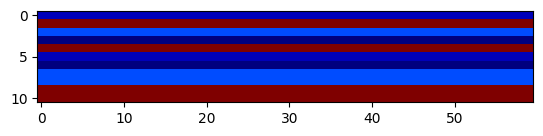

In [10]:
plt.imshow(arr.real, cmap='jet')

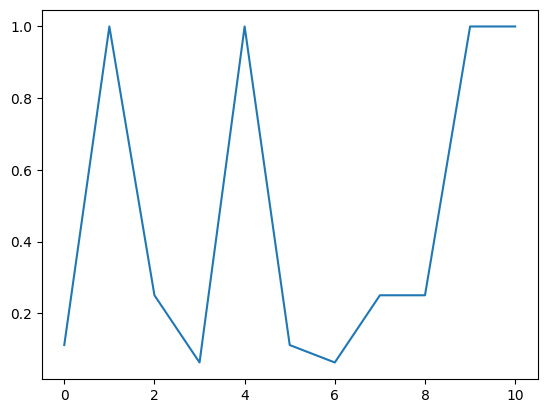

In [11]:
plt.plot(arr[:,0].real)

In [12]:
labels = ref.get_ref_labels(iz)

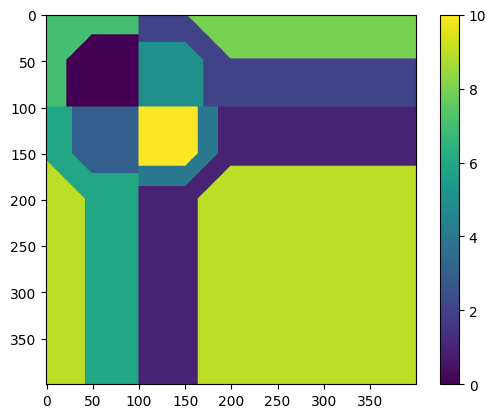

In [13]:
plt.imshow(labels[5,:,:])
plt.colorbar()

In [14]:
arr[:,5]

array([0.11111401-0.09384798j, 1.        -0.04443133j,
       0.25      -0.06529049j, 0.0625    -0.01523926j,
       1.        -0.14285767j, 0.1111088 -0.01523926j,
       0.0625    -0.09384785j, 0.25      -0.12237076j,
       0.25      -0.00786851j, 1.        -0.00387423j,
       0.99999994-0.08540819j])

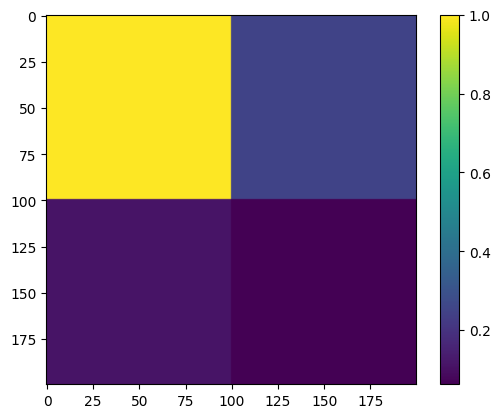

In [15]:
plt.imshow(slow[iz, 0, :, :].real)
plt.colorbar()

In [16]:
ns = [nx,ny,nw,nsrc]
ds = [0.01, 0.01, dw, 1]
os = [0,   0,   0.,   0]

data = SepVector.getSepVector(ns=ns, ds=ds, os=os, storage='dataComplex')

In [17]:
isrc = 5
nd = data[isrc,:,:,:]
nd[:nw,99,99] = W[:nw]

In [18]:
# data[:, :, 250, 250] = W[:]
fft = data.clone()

sig = 3
data[:] = gaussian_filter(data[:], sigma=(1,1,sig,sig))

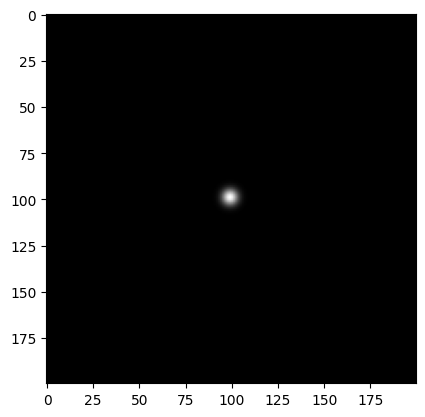

In [19]:

plt.imshow(np.abs(data[isrc,5,:,:]), cmap='gray')

In [ ]:
pspi = CudaWEM.PSPI(data, data, slow, par)
pspi.set_depth(iz)

In [ ]:
next_wfld = data.clone()
next_wfld2 = data.clone()

In [ ]:
for _ in range(5):
    pspi.forward(False, data, next_wfld)
    data[:] = next_wfld[:]

In [ ]:
wfld = np.zeros((Nt, ny, nx), dtype=complex)
wfld[:nw, :, :] = next_wfld[isrc, :, :, :]
wfld[:] = np.fft.ifft(wfld, axis=0).real

In [ ]:
plt.plot(wfld[:,50,50].real)

In [ ]:
import holoviews as hv 
hv.extension('matplotlib')
hv.output(widget_location='bottom')

In [ ]:
snaps = {}
every = 5
pclip = .01
amin = pclip * np.amin(wfld.real)
amax = pclip * np.amax(wfld.real)
# wfld_c = np.clip(wfld.real, amin, amax)

for i in range(0, Nt, every):
    snaps[i] = hv.Image(wfld[i,:,:].real).opts(cmap='gray', clim=(amin, amax))

In [ ]:
hmap = hv.HoloMap(snaps, kdims='Time')
hmap

In [ ]:
iy = 130
for i in range(0, Nt, every):
    snaps[i] = hv.Curve(wfld[i,iy,:].real)

In [ ]:
hmap = hv.HoloMap(snaps, kdims='Time')
hmap

## Can we reverse the waves?
We continue propagating from previous steps to see if we can reverse the process exactly

In [ ]:
nsteps = [1]
prev_wfld = data.clone()
orig = data.clone()

for i in nsteps:
    for _ in range(i):
        pspi.forward(False, data, next_wfld)
        data[:] = next_wfld[:]
        pspi.adjoint(False, prev_wfld, next_wfld)
        next_wfld[:] = prev_wfld[:]
        data.scaleAdd(prev_wfld, 1, -1)
        print(np.linalg.norm(prev_wfld[:]-data[:]) / np.linalg.norm(data[:]))
    

In [ ]:
# pspi.dotTest(verbose=True)